YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed


Testing stationarity of market returns:
ADF Statistic: -7.9436
p-value: 0.0000
Stationary


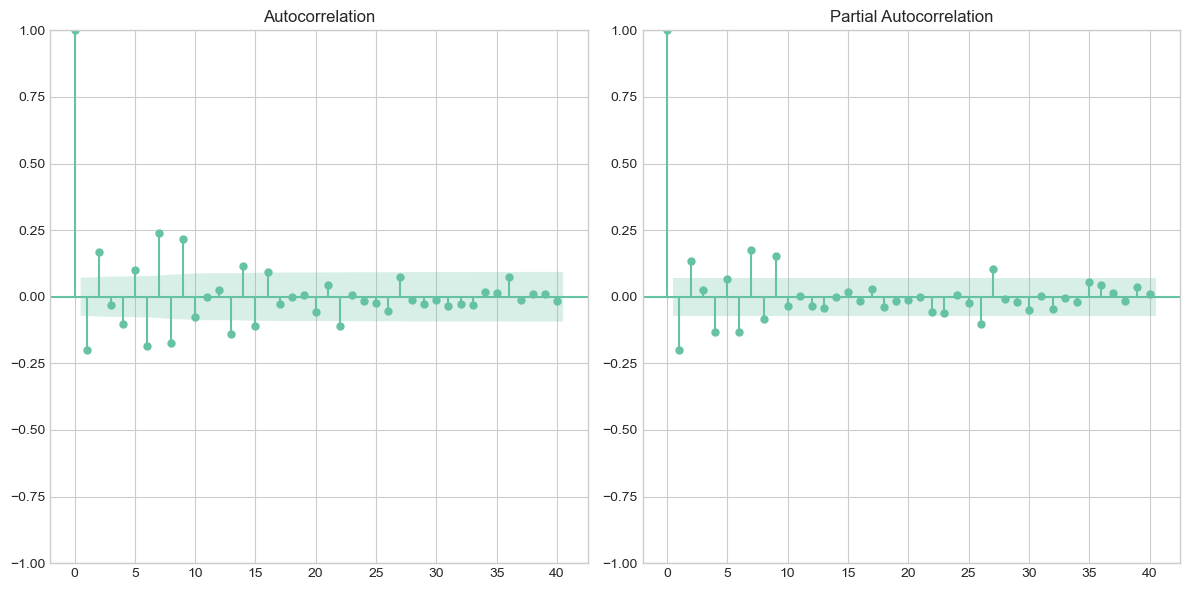

Finding optimal ARIMA parameters..........
Best ARIMA Parameters: (2, 0, 2) (AIC: -4182.85)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  755
Model:                 ARIMA(2, 0, 2)   Log Likelihood                2097.426
Date:                Sat, 05 Apr 2025   AIC                          -4182.853
Time:                        21:25:18   BIC                          -4155.092
Sample:                             0   HQIC                         -4172.159
                                - 755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.833      0.405      -0.001       0.002
ar.L1         -0.5584      0.192     -2

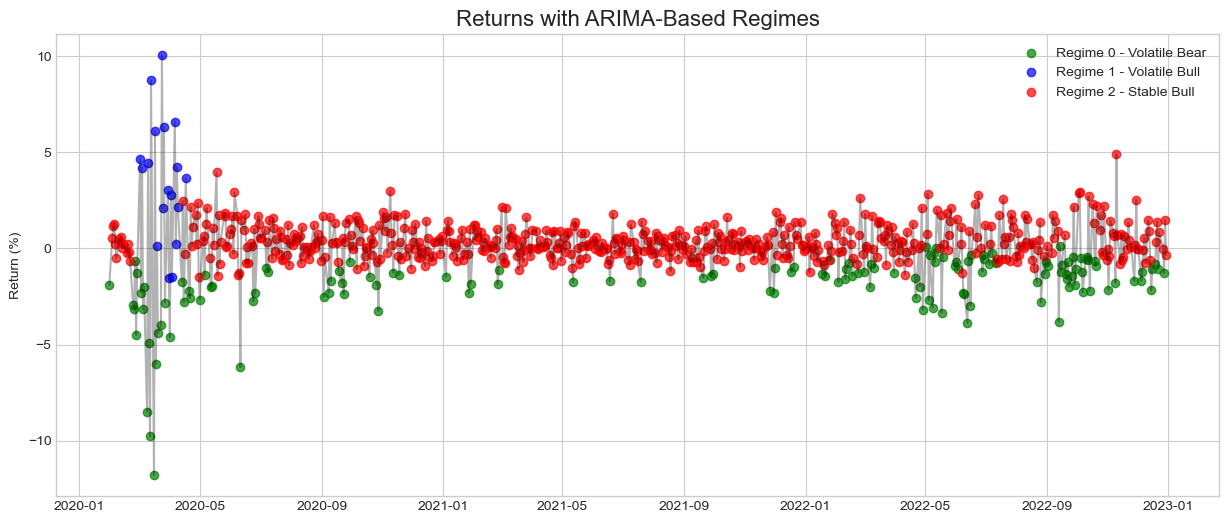


Regime Statistics:

Regime 0 - Volatile Bear (18.8% of time)
  • Avg Daily Return: -1.9052%
  • Annualized Volatility: 26.45%
  • Duration: 138 days

Regime 1 - Volatile Bull (2.4% of time)
  • Avg Daily Return: 3.6850%
  • Annualized Volatility: 50.87%
  • Duration: 18 days

Regime 2 - Stable Bull (78.8% of time)
  • Avg Daily Return: 0.3988%
  • Annualized Volatility: 13.63%
  • Duration: 580 days


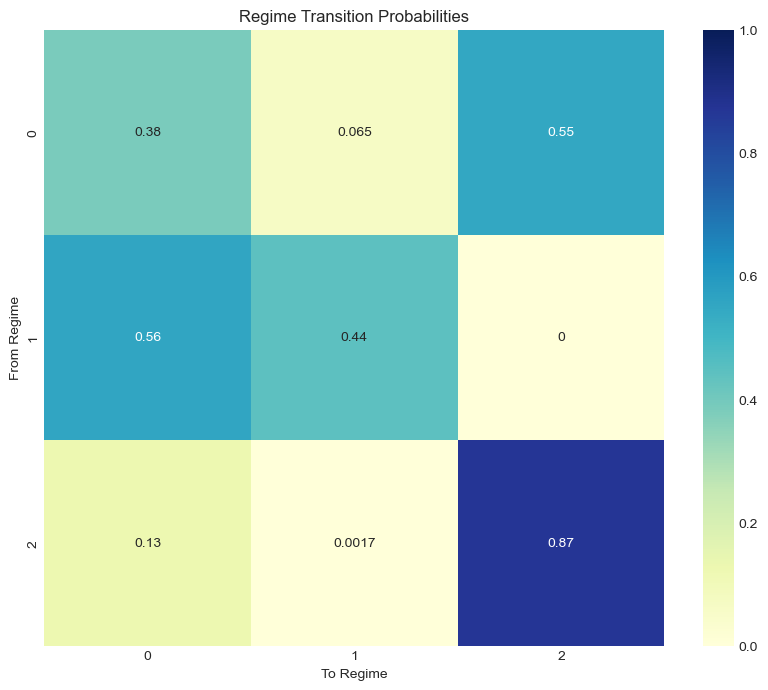


Transition Matrix:
          0         1         2
0  0.384058  0.065217  0.550725
1  0.555556  0.444444  0.000000
2  0.127807  0.001727  0.870466

Forecasting future returns...


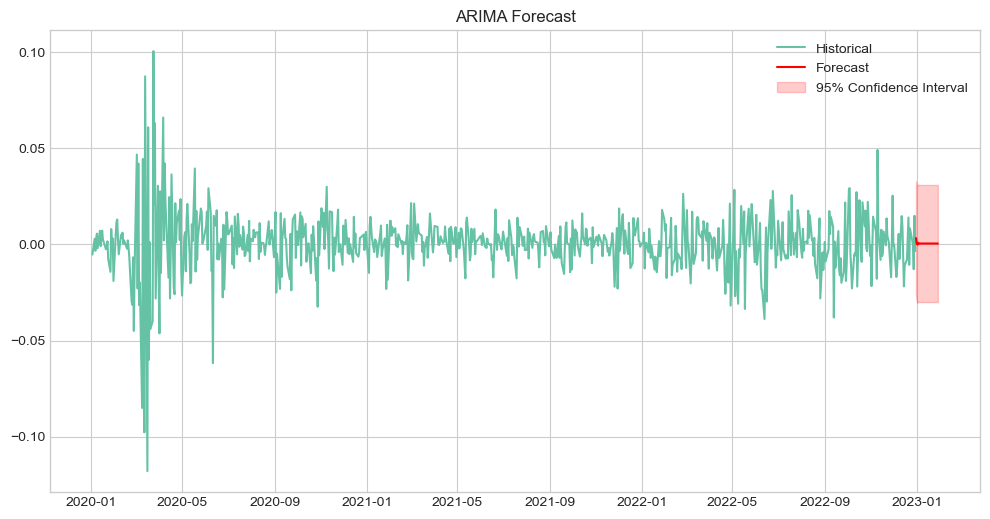


References:
1. Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2015). Time Series Analysis: Forecasting and Control.
2. Dahlhaus, R. (1997). Fitting time series models to nonstationary processes.
3. Ang, A., & Timmermann, A. (2012). Regime changes and financial markets.


In [1]:
# Market Regime Analysis with ARIMA Models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

def fetch_stock_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    return data.dropna()

def test_stationarity(series):
    # Test stationarity of a time series using ADF test
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print("Stationary" if result[1] <= 0.05 else "Non-stationary")
    return result[1] <= 0.05

def find_optimal_arima_params(series, max_order=3):
    # Use AIC to formulate ARIMA params
    best_aic = float('inf')
    best_params = None
    
    for p in range(max_order + 1):
        for d in range(max_order + 1):
            for q in range(max_order + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    model_fit = model.fit()
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_params = (p, d, q)
                        best_model = model_fit
                except:
                    continue
    
    print(f'Best ARIMA Parameters: {best_params} (AIC: {best_aic:.2f})')
    return best_model, best_params

def detect_regimes_with_arima(series, model_fit, n_regimes=3):
    # Get residuals and calculate rolling statistics
    residuals = model_fit.resid
    window = 20
    roll_mean = residuals.rolling(window=window).mean()
    roll_std = residuals.rolling(window=window).std()
    
    # Create features for regime detection
    features = pd.DataFrame({
        'residual': residuals,
        'roll_mean': roll_mean,
        'roll_std': roll_std,
        'original': series
    }).dropna()
    
    # Standardize features and apply K-Means
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=n_regimes, random_state=42, n_init=10)
    regimes = kmeans.fit_predict(scaled_features)
    features['regime'] = regimes
    
    # Calculate regime statistics
    regime_stats = {}
    for regime in range(n_regimes):
        regime_data = features[features['regime'] == regime]
        avg_return = regime_data['original'].mean() * 100
        volatility = regime_data['original'].std() * 100 * np.sqrt(252)
        avg_residual = regime_data['residual'].mean()
        
        # Determine regime type
        if avg_return > 0 and volatility < np.median(features['roll_std']) * 100 * np.sqrt(252):
            label = "Stable Bull"
        elif avg_return > 0:
            label = "Volatile Bull"
        elif volatility > np.median(features['roll_std']) * 100 * np.sqrt(252):
            label = "Volatile Bear"
        else:
            label = "Stable Bear"
        
        regime_stats[regime] = {
            'label': label,
            'avg_return': avg_return,
            'volatility': volatility,
            'avg_residual': avg_residual,
            'duration': len(regime_data),
            'pct_time': len(regime_data) / len(features) * 100
        }
    
    # Plot regimes over time
    plt.figure(figsize=(15, 6))
    colors = {0: 'green', 1: 'blue', 2: 'red', 3: 'purple'}
    
    for regime in range(n_regimes):
        regime_data = features[features['regime'] == regime]
        label = f"Regime {regime} - {regime_stats[regime]['label']}"
        plt.scatter(
            regime_data.index,
            regime_data['original'] * 100,
            c=colors.get(regime, 'gray'),
            label=label,
            alpha=0.7
        )
    
    plt.plot(features.index, features['original'] * 100, color='black', alpha=0.3)
    plt.title('Returns with ARIMA-Based Regimes', fontsize=16)
    plt.ylabel('Return (%)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return features, regime_stats

def forecast_with_arima(series, model_fit, steps=30):
    forecast = model_fit.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int(alpha=0.05)
    
    # Plot forecast
    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series, label='Historical')
    
    forecast_dates = pd.date_range(start=series.index[-1], periods=steps+1)[1:]
    plt.plot(forecast_dates, forecast_mean, label='Forecast', color='red')
    plt.fill_between(
        forecast_dates, 
        forecast_ci.iloc[:, 0], 
        forecast_ci.iloc[:, 1], 
        color='red', 
        alpha=0.2, 
        label='95% Confidence Interval'
    )
    
    plt.title('ARIMA Forecast')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return forecast_mean, forecast_ci

def create_transition_matrix(regimes):
    # Count transitions
    max_regime = int(regimes.max())
    transition_counts = np.zeros((max_regime + 1, max_regime + 1), dtype=int)
    
    for i in range(len(regimes) - 1):
        transition_counts[regimes.iloc[i], regimes.iloc[i+1]] += 1
    
    # Convert to probabilities
    transition_probs = np.zeros_like(transition_counts, dtype=float)
    for i in range(transition_counts.shape[0]):
        row_sum = transition_counts[i].sum()
        if row_sum > 0:
            transition_probs[i] = transition_counts[i] / row_sum
    
    # Plot heatmap
    transition_df = pd.DataFrame(transition_probs)
    plt.figure(figsize=(10, 8))
    sns.heatmap(transition_df, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
    plt.title("Regime Transition Probabilities")
    plt.xlabel("To Regime")
    plt.ylabel("From Regime")
    plt.show()
    
    return transition_df

# Main analysis function
def analyze_market_with_arima(tickers, start_date, end_date, n_regimes=3):
    # Fetch data
    prices_df = fetch_stock_data(tickers, start_date, end_date)
    returns_df = prices_df.pct_change().dropna()
    
    # Create market index (average of all assets)
    market_returns = returns_df.mean(axis=1)
    
    # Check stationarity
    print("Testing stationarity of market returns:")
    is_stationary = test_stationarity(market_returns)
    
    # Plot ACF and PACF
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(market_returns.dropna(), ax=plt.gca(), lags=40)
    plt.subplot(122)
    plot_pacf(market_returns.dropna(), ax=plt.gca(), lags=40)
    plt.tight_layout()
    plt.show()
    
    # Find optimal ARIMA parameters
    print("Finding optimal ARIMA parameters..........")
    model_fit, params = find_optimal_arima_params(market_returns, max_order=2)
    
    # Summary of the model
    print(model_fit.summary())
    
    # Detect regimes
    print("Detecting market regimes...")
    regime_df, regime_stats = detect_regimes_with_arima(market_returns, model_fit, n_regimes)
    
    # Print regime statistics
    print("\nRegime Statistics:")
    for regime, stats in regime_stats.items():
        print(f"\nRegime {regime} - {stats['label']} ({stats['pct_time']:.1f}% of time)")
        print(f"  • Avg Daily Return: {stats['avg_return']:.4f}%")
        print(f"  • Annualized Volatility: {stats['volatility']:.2f}%")
        print(f"  • Duration: {stats['duration']} days")
    
    # Analyze transitions
    transition_matrix = create_transition_matrix(regime_df['regime'])
    print("\nTransition Matrix:")
    print(transition_matrix)
    
    # Forecast
    print("\nForecasting future returns...")
    forecast_mean, forecast_ci = forecast_with_arima(market_returns, model_fit, steps=30)
    
    return {
        'model': model_fit,
        'regimes': regime_df,
        'regime_stats': regime_stats,
        'transition_matrix': transition_matrix,
        'forecast': (forecast_mean, forecast_ci)
    }

# Define tickers and time period
tickers = [
    "SPY", "XLF", "XLK", "XLE", "XLU", "XLV", 
    "XLP", "XLI", "XLB", "XLRE", "XLC"
]

# Set analysis period
start_date = "2020-01-01"
end_date = "2023-01-01"

# Run the analysis
results = analyze_market_with_arima(tickers, start_date, end_date, n_regimes=3)

# Citation
print("\nReferences:")
print("1. Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2015). Time Series Analysis: Forecasting and Control.")
print("2. Dahlhaus, R. (1997). Fitting time series models to nonstationary processes.")
print("3. Ang, A., & Timmermann, A. (2012). Regime changes and financial markets.")